# CustomOptimizer playground

Playground to setup and test a custom Tensorflow Optimizer.  
  
**Objectives:** 
* **Interfaces compatible with TF APIs**  ...WE WILL NOT DO THAT... (not a top priority)   
Examples: https://towardsdatascience.com/custom-optimizer-in-tensorflow-d5b41f75644a  
Basic gradient TF example:  https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/training/gradient_descent.py
* **Check Hard Constraint and if necessary perform backtracking line search to match (or until we match) the constraint**

As a test setup, we will test such an implementation on MNIST with a 'fake' constraint (it does not matter if the constraint is stupid), the purpose is to setup code and validate it in a simple context, easy to debug and check.

**Compare results with different Optimizers and some CustomOptimizer**

ONGOING: CustomOptimizer + Backtracking Line Search

## Load data
Load the MNIST data, which comes pre-loaded with TensorFlow.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../datasets/mnist", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting ../datasets/mnist/train-images-idx3-ubyte.gz
Extracting ../datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ../datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ../datasets/mnist/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

In [3]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


## Visualize Data

3


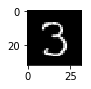

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## Preprocess Data

In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup Tensorflow

In [6]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

In [7]:
def LeNet(x,reuse):
    with tf.variable_scope('pi', reuse=reuse): # fake PI net
        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, 10)
        return out

In [ ]:
from tensorflow.contrib.layers import flatten

def LeNetRef(x, reuse):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0; sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6), name='myvar')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

## Default setup with AdamOptimizer or basic GradientDescentOptimizer

In [9]:
logits = LeNet(x, reuse=False)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

pi_loss = tf.reduce_mean(cross_entropy) # FAKE ME ..

#rate = 0.001
#optimizer = tf.train.AdamOptimizer(learning_rate = rate)
#training_operation = optimizer.minimize(loss_operation)

rate = 0.1
optimizer = tf.train.GradientDescentOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# CustomOptimizer

very first version ... nothing fancy... Basic hook and basic idea ...

In [10]:
lr = tf.placeholder(dtype=tf.float32)

In [11]:
#var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
print(var_list)
grads = tf.gradients(loss_operation, var_list)
print(grads)

[<tf.Variable 'pi/conv2d/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'pi/conv2d/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'pi/conv2d_1/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'pi/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'pi/dense/kernel:0' shape=(2304, 1024) dtype=float32_ref>, <tf.Variable 'pi/dense/bias:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'pi/dense_1/kernel:0' shape=(1024, 10) dtype=float32_ref>, <tf.Variable 'pi/dense_1/bias:0' shape=(10,) dtype=float32_ref>]
[<tf.Tensor 'gradients_1/pi/conv2d/Conv2D_grad/Conv2DBackpropFilter:0' shape=(5, 5, 1, 32) dtype=float32>, <tf.Tensor 'gradients_1/pi/conv2d/BiasAdd_grad/BiasAddGrad:0' shape=(32,) dtype=float32>, <tf.Tensor 'gradients_1/pi/conv2d_1/Conv2D_grad/Conv2DBackpropFilter:0' shape=(3, 3, 32, 64) dtype=float32>, <tf.Tensor 'gradients_1/pi/conv2d_1/BiasAdd_grad/BiasAddGrad:0' shape=(64,) dtype=float32>, <tf.Tensor 'gradients_1/pi/dense/MatMul_grad/M

In [12]:
#lr = 0.1
var_updates = []
for grad, var in zip(grads, var_list):
    var_updates.append(var.assign_sub(lr * grad))
custom_training_operation = tf.group(*var_updates)

In [13]:
#lr = 0.1
var_updates = []
for grad, var in zip(grads, var_list):
    var_updates.append(var.assign_sub(-lr * grad))
cancel_training_operation = tf.group(*var_updates)

# Backtracking Line Search

In [14]:
!ls spinup/algos/trpo

core.py  __init__.py  trpo.py


### some def extracted from trpo/core.py

In [15]:
def get_vars(scope=''):
    return [x for x in tf.trainable_variables() if scope in x.name]

def flat_concat(xs):
    return tf.concat([tf.reshape(x,(-1,)) for x in xs], axis=0)

def flat_grad(f, params):
    return flat_concat(tf.gradients(xs=params, ys=f))

def assign_params_from_flat(x, params):
    flat_size = lambda p : int(np.prod(p.shape.as_list())) # the 'int' is important for scalars
    splits = tf.split(x, [flat_size(p) for p in params])
    new_params = [tf.reshape(p_new, p.shape) for p, p_new in zip(params, splits)]
    return tf.group([tf.assign(p, p_new) for p, p_new in zip(params, new_params)])

In [16]:
pi_params = get_vars('pi')
print(pi_params)
gradient = flat_grad(pi_loss, pi_params)
print(gradient) # More than 2 millions params ...

[<tf.Variable 'pi/conv2d/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'pi/conv2d/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'pi/conv2d_1/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'pi/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'pi/dense/kernel:0' shape=(2304, 1024) dtype=float32_ref>, <tf.Variable 'pi/dense/bias:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'pi/dense_1/kernel:0' shape=(1024, 10) dtype=float32_ref>, <tf.Variable 'pi/dense_1/bias:0' shape=(10,) dtype=float32_ref>]
Tensor("concat:0", shape=(2389898,), dtype=float32)


In [17]:
v_ph = tf.placeholder(tf.float32, shape=gradient.shape)

In [18]:
# Symbols for getting and setting params
get_pi_params = flat_concat(pi_params)
set_pi_params = assign_params_from_flat(v_ph, pi_params)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [23]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    graph = tf.get_default_graph()
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
            old_params = sess.run(get_pi_params)
            sess.run(custom_training_operation, feed_dict={x: batch_x, y: batch_y, lr : 0.1})
            
            # WE CAN CANCEL AN UPDATE ... that's mainly all we need... technically
            # to perform a backtracking line search
            # just change the LR in between and run a custom_training_operation
            # with a lower learning rate
            if i%2 == 0:
                sess.run(set_pi_params, feed_dict={v_ph: old_params})
                #sess.run(cancel_training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.6f}".format(validation_accuracy))
        print()
    
    saver.save(sess, './data/lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.145600

EPOCH 2 ...
Validation Accuracy = 0.970200

EPOCH 3 ...
Validation Accuracy = 0.970200

EPOCH 4 ...
Validation Accuracy = 0.978200

EPOCH 5 ...
Validation Accuracy = 0.978200

EPOCH 6 ...
Validation Accuracy = 0.984400

EPOCH 7 ...
Validation Accuracy = 0.984400

EPOCH 8 ...
Validation Accuracy = 0.985600

EPOCH 9 ...
Validation Accuracy = 0.985600

EPOCH 10 ...
Validation Accuracy = 0.987400

Model saved


## Evaluate the Model

In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./data/'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./data/lenet
Test Accuracy = 0.990
